# Загрузка и анализ данных из модели

Как запускать эксперимент над моделью:

* открыть Netlogo, открыть в ней модель
* выбрать в меню Tools -> Behaviour Space
* завести эксперимент:
  * в переменных указать run-name: это название эксперимента, гипотезы, версия модели и т.п.
  * в переменных указать seed, например, для ста рзных сидов -- [0, 1, 100] 
  * задать все остальные нужные переменные
* запустить эксперимент

Модель сохранит логи, и их можно будет открыть кодом ниже.

In [1]:
%matplotlib inline
import os
import re
from glob import glob
import sqlalchemy
import pandas as pd

# Class definition

In [2]:
_filename_re = re.compile(
    '.*/(?P<run_name>[a-zA-Z0-9\-]+)_seed(?P<seed>\d+)_(?P<breed>[a-zA-Z0-9\-]+)_tick(?P<tick>\d+)\.csv$'
)


class Reader:
    """
    Reads log files and makes dataframes.
    """
    def __init__(self, path, run_name):
        self._path = path
        self._run_name = run_name
        self._scan_logfiles()
        
    def _scan_logfiles(self):
        paths = []
        for path in glob(f'{self._path}/{self._run_name}_seed*_*_tick*.csv'):
            if not _filename_re.match(path):
                continue
            attr = _filename_re.search(path).groupdict()
            #attr['breed_type'] = 'link' if attr['breed'].endswith('_link') else 'agent'
            attr['path'] = path
            attr['tick'] = int(attr['tick'])
            attr['seed'] = int(attr['seed'])
            attr['filesize'] = os.path.getsize(path)
            paths.append(attr)
        self._logfiles = pd.DataFrame.from_records(paths)

    @property
    def breed_names(self):
        return self._logfiles['breed'].unique()
    
    def __repr__(self):
        return f"""\
Logs reader
===========
run name: {self._run_name}
path: {self._path}
max tick: {self._logfiles['tick'].max()}
seeds cnt: {self._logfiles['seed'].nunique()}
breeds: {', '.join(self.breed_names)}
logs total size: {self._logfiles['filesize'].sum() / 1024 / 1024:.0f}MB
"""
              
    def read_breed(self, breed):
        """Read all data for a given breed."""
        accum = []
        for _, attr in self._logfiles.query(f"breed == '{breed}'").iterrows():
            accum.append(pd.read_csv(attr['path']).assign(seed=attr['seed']))
        return pd.concat(accum)
    
    def _is_link(self, breed):
        return True if breed.endswith('-link') else False
    
    @property
    def link_names(self):
        return [breed for breed in self.breed_names if self._is_link(breed)]
    
    def read_all_breeds(self):
        self._breeds_data = {}
        for breed in self.breed_names:
            print(f'Reading {breed}... ', end='')
            df = self.read_breed(breed)
            print(f" done. ", end='')
            if not self._is_link(breed):
                id_col = breed + '_id'
                print(f" {df[id_col].nunique()} unique agents.", end='')
            self._breeds_data[breed] = df
            print()
        print('All done.')
        self._check_data()
        
    def _check_data(self):
        for link in self.link_names:
            id_cols = [col for col in self.d[link].columns if col.endswith('_id')]
            breeds = [col[:-3] for col in id_cols]
            print(f"{link} is linked to:", ", ".join(breeds))
            for id_col, breed in zip(id_cols, breeds):
                if breed not in self.d:
                    print(f" - {breed}: couldn't find such a breed!")
                    continue
                breed_ids = self.d[breed][id_col].unique()
                link_breed_ids = self.d[link][id_col].unique()
                intersection = set(breed_ids).intersection(set(link_breed_ids))
                print(
                    f" - {breed}: {len(breed_ids)} agents vs {len(link_breed_ids)} link ids, "
                    f"intersection {len(intersection)/len(breed_ids)*100:.1f}%")
        
    @property
    def d(self):
        return self._breeds_data
    
    @property
    def dbconn(self):
        if not hasattr(self, '_dbconn'):
            curdir = os.path.abspath(os.path.dirname('.'))
            self._dbconn = sqlalchemy.create_engine(
                'sqlite:///' + curdir + '/export_' + self._run_name + '.sqlite')
        return self._dbconn
    
    def dump_to_db(self):
        for breed in self.breed_names:
            self.d[breed].to_sql(breed, con=self.dbconn, if_exists='replace', index=False)
            
    def sql(self, query):
        return pd.read_sql(query, con=self.dbconn)

# Reading data

In [3]:
reader = Reader('./export/', 'exp01')
reader

Logs reader
run name: exp01
path: ./export/
max tick: 490
seeds cnt: 101
breeds: user, unit
logs total size: 31MB

In [4]:
reader.read_all_breeds()

Reading user...  done.  50 unique agents.
Reading unit...  done.  250 unique agents.
All done.


In [5]:
reader.dump_to_db()

# Exploring data

In [ ]:
def plot_seeds(df, col, agg):
    plot = (df
     .groupby(['seed', 'tick'])
     [col]
     .agg(agg)
     .groupby('seed')
     .plot(alpha=0.2, linewidth=1, color='k')
    )

## Users table

Можно брать данные прямо из объекта `Reader` - это обычные датафреймы, можно работать с ними в питоне.

In [ ]:
reader.d['user']

In [ ]:
plot_seeds(reader.d['user'], 'unit_cnt', 'max')

## Combining parameters

Если мы загрузили данные в базу функцией `dump_to_db`, можем писать sql-запросы в базу и работать привычным для аналитика способом. Можно даже прицепить какую-нибудь BI-систему к этой базе или открыть её в Табло.

!!! Не забывайте джойнить по seed и tick, иначе получите кашу из данных от разных запусков модели.

In [6]:
reader.sql("""
select unit.*, user.activity
from unit
left join user on (
    unit.owner = user.user_id
    and unit.seed = user.seed
    and unit.tick = user.tick
    )
where
    unit.seed = 1
""")

,unit_id,tick,category,on_sale,owner,seed,activity
0,284,300,15,0,39,1,0.611658
1,290,300,15,0,33,1,0.558738
2,210,300,15,0,41,1,0.697104
3,259,300,15,0,28,1,0.629269
4,195,300,15,0,38,1,0.131669
...,...,...,...,...,...,...,...
12495,205,370,15,0,9,1,0.315741
12496,270,370,105,0,43,1,0.575802
12497,162,370,55,0,19,1,0.583243
12498,58,370,15,0,45,1,0.535074


In [11]:
activity_vs_units = reader.sql("""
with 
unit_ as (
    select 
        unit.*
        , user.activity
        , user.user_id
    from 
        unit
    left join 
        user on (
            unit.owner = user.user_id
            and unit.seed = user.seed
            and unit.tick = user.tick
            )
    )
, user_ as (
    select
        seed
        , tick
        , user_id
        , max(activity) as activity
        , count(*) as unit_cnt
    from
        unit_
    group by
        seed, tick, user_id
    )
select
    seed
    , user_id
    , max(activity) as activity
    , max(unit_cnt) as unit_cnt_max
    , min(unit_cnt) as unit_cnt_min
    --, median(unit_cnt) as unit_cnt_median
    , avg(unit_cnt) as unit_cnt_avg
from 
    user_
group by 
    seed, user_id
""")

<AxesSubplot: xlabel='activity', ylabel='unit_cnt_avg'>

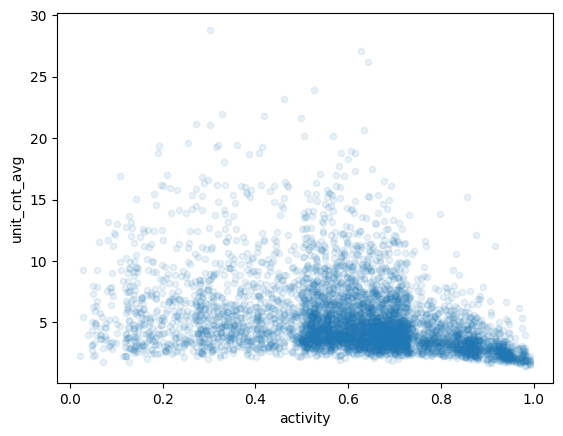

In [16]:
activity_vs_units.plot(x='activity', y='unit_cnt_avg', kind='scatter', alpha=0.1)

# Merging data

В этом классе можно описать создание витрин и все разом их загрузить в базу. Удобно перетаскивать сюда код (питоновский и sql), которым выше посчитали что-то интересное и хотим рассчитывать эту таблицу в будущем.

In [ ]:
class Combiner:
    """
    Combines raw dataframes into data marts.
    """
    def __init__(self, reader: Reader):
        self._reader = reader
        
    @property
    def m(self):
        return self._marts
        
    def make_marts(self):
        self._marts = {}
        #self._marts['ad'] = self._append_linked_breed(self._reader.d['ad'], 'ad', 'platform', 'ad-platform-link')

    def _append_linked_breed(self, df, breed1: str, breed2: str, link: str):
        """
        Given one breed and another one linked with the first one,
        make a cartesian product dataframe with info on both.

        Left one is the main one (we join left-wise).
        """
        assert breed1 in self._reader.d
        assert breed2 in self._reader.d
        assert link in self._reader.d
        assert f'{breed1}_id' in df
        df2 = self._reader.d[breed2].copy()
        df2.columns = [
            col if col in ['seed', 'tick', f'{breed2}_id'] else f'{breed2}_{col}' 
            for col in df2.columns
        ]
        res = (df
            .merge(
                self._reader.d[link],
                left_on=['seed', 'tick', f'{breed1}_id'], 
                right_on=['seed', 'tick', f'{breed1}_id'], 
                how='left')
            .merge(
                df2,
                left_on=['seed', 'tick', f'{breed2}_id'], 
                right_on=['seed', 'tick', f'{breed2}_id'],
                how='left')
            )
        return res

In [ ]:
combiner = Combiner(reader)
combiner.make_marts()